# Toy Problem #1


Approach: Read the data in from the csv files.

- Create a GeoDataFrame object out of this
- Create a dual graph so that each node represents a street and the geometries between them
- Use VRP process on nodes

New Heuristics Approach: based on https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=5362&context=etd



# Step 1 - Read Data and Create Graph

In [124]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np

Read the edges and nodes

In [125]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

Create graph

In [126]:
G = nx.Graph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})  


Take a step back and visualize the data in our graph

In [127]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

# of edges: 6
# of nodes: 5
[('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes': 1}), ('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes': 1}), ('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes': 1}), ('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes': 1}), ('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2}), ('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})]
[('depot', {'x': 0, 'y': 0}), ('home', {'x': 1, 'y': 0}), ('school', {'x': 0, 'y': 2}), ('grocery', {'x': 5, 'y': 2}), ('hospital', {'x': 3, 'y': 7})]


##### Visualize the Graph

In [128]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])


{'depot': (0, 0),
 'home': (1, 0),
 'school': (0, 2),
 'grocery': (5, 2),
 'hospital': (3, 7)}

Now plot

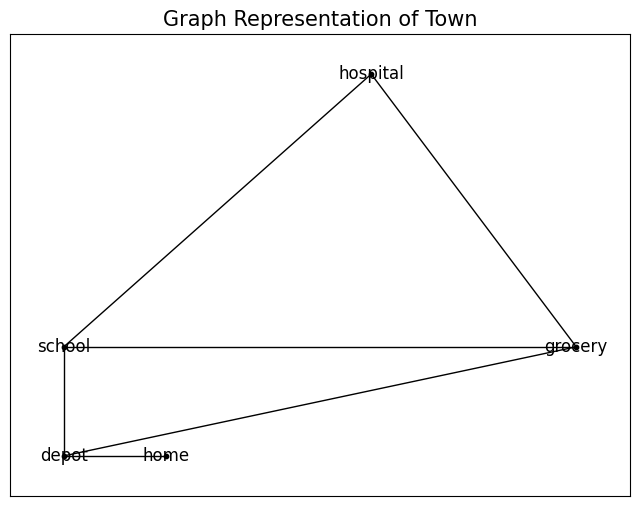

In [129]:
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

Visualize Paramters

In [130]:
for edge in G.edges(data=True):
    print(edge)

('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes': 1})
('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes': 1})
('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes': 1})
('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes': 1})
('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})
('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2})


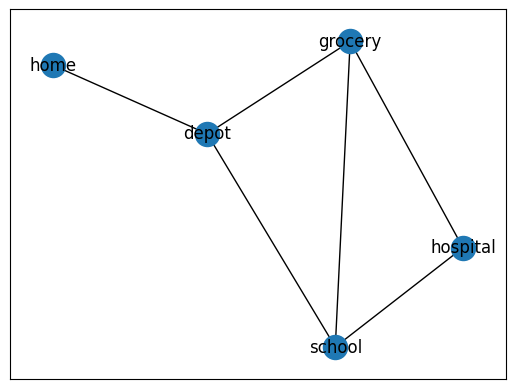

In [131]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G, pos=spring_pos, with_labels=True)
plt.show()

# Step 2: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

Initialize model parameters

In [132]:
number_of_routes = 0 # set initial number of routes to zero
curr_node = 'depot' # set starting node to depot
alpha = 0.4 # set alpha parameter
arcs_left = sum([edge[2]['passes'] for edge in G.edges(data=True)]) # set initial arcs left to all edges

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

In [133]:
for node in G.nodes:
    eff_deg = 0
    for edge in G.edges([node], data=True):
        eff_deg += edge[2]['passes']
    G.nodes[node]['effective_degree'] = eff_deg

# print result
for node in G.nodes(data=True):
    print(node)

('depot', {'x': 0, 'y': 0, 'effective_degree': 3})
('home', {'x': 1, 'y': 0, 'effective_degree': 1})
('school', {'x': 0, 'y': 2, 'effective_degree': 4})
('grocery', {'x': 5, 'y': 2, 'effective_degree': 4})
('hospital', {'x': 3, 'y': 7, 'effective_degree': 4})


Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

Define a cost function for traversing an arc

In [134]:
def cost(G, node1, node2):
    '''
    Returns the cost of traversing an edge between two nodes. Doesn't include priorities yet. 
    Currently based solely on distance.
    '''
    edge_data = G.get_edge_data(node1, node2)

    cost = edge_data['distance']
    return cost

### Start finding a route

In [135]:
partial_route = [] # initialize route list
partial_cost = 0

Check if there are any required arcs remaining departing from the current node

In [190]:
def visit_arc(G, arc, route=partial_route, c=partial_cost, undirected=True):
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        c (float): The partial cost incurred so far (default: partial_cost)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        int: The new node that the arc is on
    '''

    # not deadheading. If deadheading, don't update effective degree
    if (G[arc[0]][arc[1]]['passes'] > 0):
        if (undirected):
            G.nodes[arc[0]]['effective_degree'] -= 1
            G.nodes[arc[1]]['effective_degree'] -= 1
        else:
            G.nodes[arc[0]]['effective_degree'] -= 1
    
    G[arc[0]][arc[1]]['passes'] -= 1
    
    route.append((arc[0], arc[1]))
    c += cost(G, arc[0], arc[1])
    return arc[1]

In [137]:
def process_node(G, curr_node):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr_node], data=True):
        if edge[2]["passes"] > 0:
            required.append(edge)
            c_min = min(cost(G, edge[0], edge[1]), c_min)
            c_max = max(cost(G, edge[0], edge[1]), c_max)
    return required, c_min, c_max

In [138]:
def find_nearest_required(G, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    # get the 1d numpy array corresponding to the distances from the node to all other nodes
    dists = distances[node]

    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for n in G.nodes():
        if n == node:
            continue
        if G.nodes[n]['effective_degree'] > 0 and dists[n] < min_dist:
            min_dist = dists[n]
            min_dist_node = n
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.reconstruct_path(node, min_dist_node, predecessors)
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    return edges
        

Initialize RCL and parameter list if there is at least one required arc

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random

Continue running the route construction algorithm until there are no required nodes in the graph left

Run the algorithm on a copy of G so that the original graph is preserved

In [139]:
def RCA(G, curr_node, alpha, route, c=partial_cost):
    while True:
        required_arcs, c_min, c_max = process_node(G, curr_node)
        rcl = [] # initialize restricted candidate list

        # chooes an arc based on restricted candidate list if not empty
        if len(required_arcs) > 0:
            for edge in required_arcs:
                if cost(G, edge[0], edge[1]) >= c_min and cost(G, edge[0], edge[1]) <= c_min + alpha*(c_max-c_min):
                    rcl.append(edge)
            chosen_arc = random.choice(rcl)
            curr_node = visit_arc(G, chosen_arc, route=route, c=c)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, curr_node)
            # no more required arcs in the graph, so we're done. This is the stopping condition of the loop
            if path is None:
                break
            for edge in path:
                curr_node = visit_arc(G, edge, route=route, c=c)
    return route

In [140]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 0.4 # set alpha parameter
arcs_left = sum([edge[2]['passes'] for edge in G.edges(data=True)]) # set initial arcs left to all edges
G_copy = G.copy()
route = []

route = RCA(G_copy, curr_node, alpha, route)
for edge in route:
    print(edge)

('depot', 'school')
('school', 'hospital')
('hospital', 'school')
('school', 'grocery')
('grocery', 'hospital')
('hospital', 'grocery')
('grocery', 'depot')
('depot', 'home')


Can update this. arcs_left is never the limiting factor, also, I wrote a method to do this

Plot the partial route

In [160]:
def plot_routes(routes):
    route1 = routes[0]
    route2 = routes[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    nx.set_edge_attributes(G,"", "plot_sequence")
    # Plot route 1
    ax1.set_title('Route 1', size=15)
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True, ax=ax1)
    for i, edge in enumerate(route1):
        G[edge[0]][edge[1]]['plot_sequence'] += str(i+1) + ' '
    for edge in route1:
        x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2
        y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
        ax1.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color='blue', fontsize=12, fontweight='bold')

    # Plot route 2
    nx.set_edge_attributes(G,"", "plot_sequence")

    ax2.set_title('Route 2', size=15)
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True, ax=ax2)
    for i, edge in enumerate(route2):
        G[edge[0]][edge[1]]['plot_sequence'] += str(i+1) + ' '
    for edge in route2:
        x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2
        y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
        ax2.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color='red', fontsize=12, fontweight='bold')

    plt.show()
        


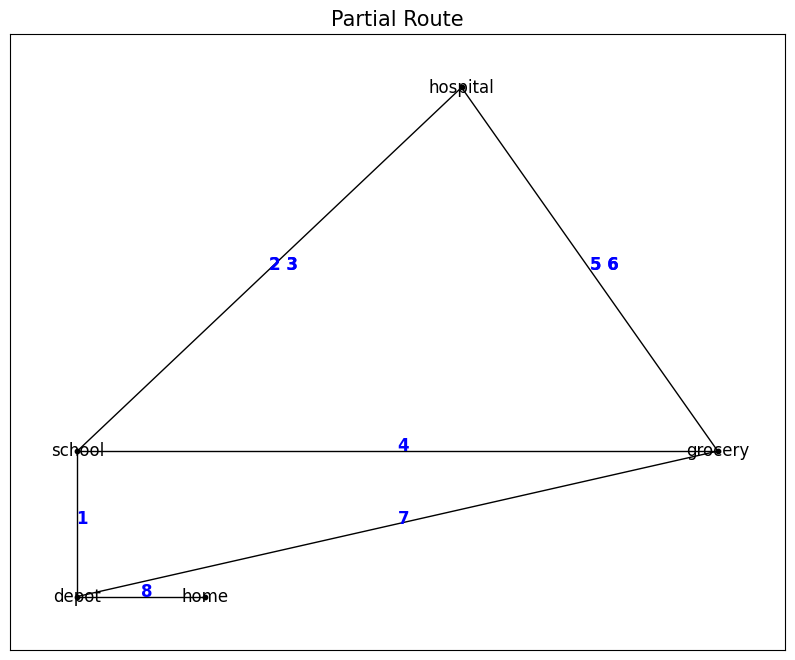

In [161]:
def plot_route(route):
    nx.set_edge_attributes(G,"", "plot_sequence")

    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)
    for i, edge in enumerate(route):
        G[edge[0]][edge[1]]['plot_sequence'] += str(i+1) + ' '

    for edge in route:
        x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2
        y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
        plt.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color='blue', fontsize=12, fontweight='bold')
    plt.title('Partial Route', size=15)
    plt.show()

plot_route(route)

## Step 3: Generate Alternative Routes - Simulated Annealing Heuristic

#### Route Improvement (RI) algorithm connects the arcs in the new route (which may be disconnected after swaps)



First, we randomly choose an arc in the grpah to swap to an arbitrary position. Then, we reconnect the entire route using the same RCA algorithm with the new swap fixed in place.

In [163]:
def move_between_nodes(G, node1, node2, route_up_to_now):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 
    Works for non-multigraphs. Requires modification when doing it for multigraphs since floyd_warshall
    only returns nodes, not edges in the shortest path.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    node_path = nx.reconstruct_path(node1, node2, predecessors)
    
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    for edge in edges:
        visit_arc(G, edge, route=route_up_to_now)

In [213]:
def rand_swap(G, route):
    '''
    Randomly swaps two edges in a route
    '''
    
    new_route = route.copy()
    i,j = random.sample(range(len(route)), 2) # choose a random edge to move to a new place
    new_location = min(i, j) # get the smaller index
    arc_to_move_index = max(i, j) # get the larger index

    arc_to_move = route[arc_to_move_index] # get the arc to move
    
    if new_location == 0:
        prev_node = 'depot'
    else:
        prev_node = route[new_location-1][1]

    print("I and J are {} and {}".format(i, j))
    print("Swapping arcs {} and {}, which are labled {} and {}".format(route[new_location], route[arc_to_move_index], new_location+1,arc_to_move_index+1))

    # connect the previous node to the first node of the arc to move
    new_route = list()

    # move between all preserved edges of the old route
    for edge in route[:new_location]:
        visit_arc(G, edge, route=new_route)
    move_between_nodes(G, prev_node, arc_to_move[0], new_route)
    
    curr_node = arc_to_move[0]
    # make sure the arc we want to swap hasn't been visited in the shortest path to it

    if G[arc_to_move[0]][arc_to_move[1]]['passes'] > 0:
        curr_node = visit_arc(G, arc_to_move, route=new_route) # visit the arc
    print(new_route)
    print(process_node(G, arc_to_move[0]))

    new_route = RCA(G, curr_node, route=new_route, alpha=0.4)
    return new_route


I and J are 1 and 3
Swapping arcs ('school', 'hospital') and ('school', 'grocery'), which are labled 2 and 4
[('depot', 'school'), ('school', 'grocery')]
([('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes': 2, 'plot_sequence': '3 4 '})], 3, 3)


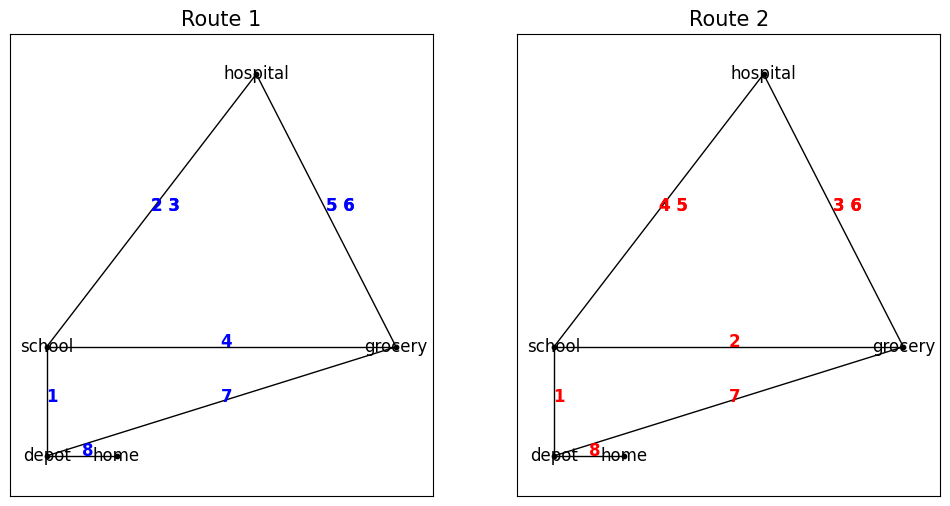

In [214]:
G_copy = G.copy()
route_new = rand_swap(G_copy, route)
plot_routes([route, route_new])

In [172]:
for i,edge in enumerate(route):
    print(i, edge)

print("\n\n\n")
for i,edge in enumerate(route_new):
    print(i, edge)

0 ('depot', 'school')
1 ('school', 'hospital')
2 ('hospital', 'school')
3 ('school', 'grocery')
4 ('grocery', 'hospital')
5 ('hospital', 'grocery')
6 ('grocery', 'depot')
7 ('depot', 'home')




0 ('depot', 'school')
1 ('school', 'hospital')
2 ('hospital', 'school')
3 ('school', 'grocery')
4 ('grocery', 'hospital')
5 ('hospital', 'grocery')
6 ('grocery', 'depot')
7 ('depot', 'home')
